In [1]:
from music_dataloader import load_input_label
from lstm import build_model, Evaluation, check_cuda
from utils import String_Encoder
import torch
import numpy as np
from compose import generate_music

In [6]:
# hyperparameters
# init note -> try anything, but start with <start>
# 99 initial notes and 301 generated notes to make it 400
init_notes = '<start>' # load_input_label('pa4Data/test.txt')[0][:99]
sampling = 'random' # 'argmax'
temperature = 1 # avaible if sampling is random
length = 400 - len(init_notes) - 1 # length of generated music sheet

print('---> check cuda')
use_cuda, device, extras = check_cuda()
print('cuda: %s' % 'yes' if use_cuda else 'no')
if use_cuda: 
    loc = 'cuda'
else: 
    loc = 'cpu'

print('----> loading setup')
init = torch.load('best model/init14.pth.tar', map_location=loc)
encoder = init['encoder']
hidden_size = init['hidden_size']
model, _, _ = build_model(input_dim=encoder.length, hidden_dim=hidden_size, device=device)

print('---> loading best model')
path = 'best model/model_best14.pth.tar'
checkpoint = torch.load(path, map_location=loc)
model.load_state_dict(checkpoint['model'])

print('---> Music sheet generated to music.txt')
notes, confs = generate_music(model, encoder, 
                              length=length, 
                              init_notes=init_notes,
                              sampling=sampling,
                              temperature=temperature,
                              device=device)

---> check cuda
no
----> loading setup
---> loading best model
---> Music sheet generated to music.txt


In [7]:
print(notes)

<start>
X:19
T:Piterstind Mornes Paderelon
T:Dickle's Recoure
R:mazurka
D:John McZK:Acu
T:Missige Darney: Se Fancy
H:Sfe a sonndine, ast O'Sourd age the cicklas of the Wiled Vallellie mastytel me 2vaix-ded and Mdowhandyre#8vedstones. on  tame. Ballig", Tobe
Z:id:hn-mazurka-1
M:3/4
K:G
dc|FA dA Be|Bd cB | B2 BA dG|F2 Ed/d/|cd cA Bd|AG FD GA|B2 Be G2||
<end>
<start>
X:9
T:Staelled Lavelin\'a Pipga
R


In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [9]:
def char_to_input(chars):
    one_hots = []
    for c in chars:
        one_hots.append(encoder.get_one_hot(c))
    tensor = torch.tensor(one_hots, dtype=torch.float).to(device)
    return tensor.view(1, len(chars), -1)

In [20]:
# forward all the notes, get the output of hidden neuron
model.eval()
ih = {'layer': 1, 'neuron': 3}
activations = []
with torch.no_grad():
    for c in notes:
        tensor = char_to_input(c)
        _ = model(tensor)
        output = model.hidden[ih['layer']].cpu().detach().numpy()
        activations.append((c, output.squeeze()[ih['neuron']]))

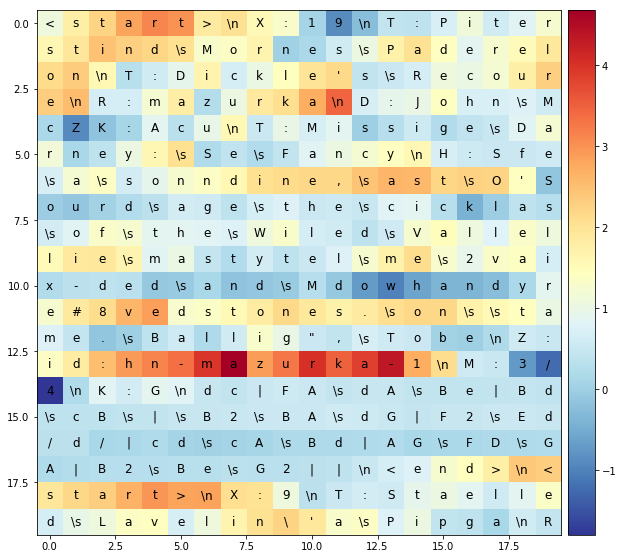

In [21]:
chars, actis = zip(*activations)
def escape(c):
    if c == '\n':
        return '\\n'
    if c == ' ':
        return '\\s'
    if c == '\t':
        return '\\t'
    return c
chars = [escape(c) for c in chars]
height, width = 20, 20
assert(len(actis) == height * width)
actis = np.array(actis).reshape(height, width)

# plot
plt.figure(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(actis,
               cmap=plt.get_cmap('RdYlBu_r'))
               # vmin=-1,
               # vmax=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)

# annotate text
inds = np.meshgrid(np.arange(actis.shape[1]), np.arange(actis.shape[0]))
for x, y, c in zip(inds[0].ravel(), inds[1].ravel(), chars):
    ax.text(x, y, c, 
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=12,
            color='k')
plt.savefig('feature.png')
plt.show()